# Шишкин Александр Эдуардович, группа 0391, Лабораторная работа 1
Средства автоматизации расчетов и моделироаания систем управления в среде Python/scipy

### Модель системы

$(1)\;\dot{dP}\;=\;17T\;+\;\zeta\;-\;0.1dP^3\;+\;9\sin\left(4dP\;-\;7\right)\;-\;6$

$(2)\;\dot T\;=\;-0.1T^3 - 2Tcos\left(5dP\;+\;6\right)\;+\;30tanh\left(I\right)\;-\;1$

где:\
T - температура\
dP - изменение давления газа в резервуаре\
I - сила тока, протекающего через нагревательный элемент\
ζ ∈ [4;23] - некотролируемое возмущение в системе

### 1. Автоматизация расчета закона управления с помощью пакета sympy

Зададим два уравнения, описывающие систему, в коде. Допускается, что аргументы тангенса находятся в окресности нуля, поэтому заменяем тангенс на простую линейную зависимость ($\;tanh\left(I\right) -> I\;$).

In [21]:
import sympy
#создание символьных переменных
dP=sympy.symbols('dP')
T=sympy.symbols('T')
zeta=sympy.symbols('zeta')
I=sympy.symbols('I')

#запись уравнений
d_dP=17 * T + zeta - 0.1 * dP**3 + 9 * sympy.sin(4 * dP - 7) - 6
d_T=-0.1 * T**3 - 2 * T * sympy.cos(5 * dP + 6) + 30 * I - 1

#печать сивольных выражений
print('Уравнения системы:')
print('dP/dt=' + str(d_dP))
print('T/dt=' + str(d_T))
print('')

Уравнения системы:
dP/dt=17*T - 0.1*dP**3 + zeta + 9*sin(4*dP - 7) - 6
T/dt=30*I - 0.1*T**3 - 2*T*cos(5*dP + 6) - 1



Определим эталонную модель процесса

$\dot{dP}\;-\;13.5\;+\;0.1dP^3\;-\;9\sin\left(4dP\;-\;7\right)\;+\;6=\;17T_d$\
За управляющее воздействие примем $17T_d$, поделим на $17$ в конце всех преобразований.

In [22]:
from sympy.solvers import solve
#вводим символ производной скорости изменения давления
ddP=sympy.symbols('ddP')
#решаем уравнение относительно 17T, "перенося" ddP вправо со знаком "-"
currentModel = solve(d_dP - ddP, 17*T)[0];
print("currentModel = " + str(currentModel));

currentModel = 0.1*dP**3 + ddP - zeta - 9.0*sin(4.0*dP - 7.0) + 6.0


Составим формулу эталонной модели с неизвестными коэффициентами

In [23]:
#определим неизвестные коэффициенты эталонной модели
C1=sympy.symbols('C1')
C2=sympy.symbols('C2')

#определим эталонную модель
etalonModel = ddP + C1 * dP + C2
print("etalonModel: " + str(etalonModel) + " = 0")
#решаем уравнение относительно управляющего воздействия U(dP,C1,C2)
U=sympy.symbols('U')
solution_U = solve((-currentModel + ddP) + U - (-etalonModel + ddP), U)[0]
print("solution_U: U = " + str(solution_U))

etalonModel: C1*dP + C2 + ddP = 0
solution_U: U = -C1*dP - C2 + 0.1*dP**3 - zeta - 9.0*sin(4.0*dP - 7.0) + 6.0


Расчитаем коэффициенты эталонной модели

In [24]:
#уравнение модели в положении равновесия
etalonBalance = -(etalonModel - ddP)
etalonBalanceSolution = solve(etalonBalance, dP)[0]
print(etalonBalance)
print("dP_d = " + str(etalonBalanceSolution))

-C1*dP - C2
dP_d = -C2/C1


Перенос в систему координат, у которой положение равновесия в нуле

In [30]:
#уравнение для переноса в новую систему координат
dP_d=sympy.symbols('dP_d')
dP_d1=dP_d + etalonBalanceSolution
print("dP_d1 = " + str(dP_d1))

#подставляем это уравнение в эталонную модель вместо dP
etalonModelNewCoordinates = (-etalonModel + ddP).subs({dP : dP_d1})
print("etalonModelNewCoordinates = " + str(sympy.expand(etalonModelNewCoordinates)))

#тогда матрица преобразований будет
print([-C1])

#находим определитель матрицы |A - E*L|, где A - матрица преобразований, L - собственные числа
L=sympy.symbols('L')
determinant = -C1 - L
print("L = ", solve(determinant, L)[0])

#вещественная часть собственных чисел должна быть < 0 => C1 > 0
#выберем C1 = 2, тогда C2 = -dP_d*C1 = -2dP_d
#подставим полученные коэффициенты в функцию управляющего воздействия
U = solution_U.subs({C1: 2, C2: -2*dP_d})
print("U = ", solution_U.subs({C1: 2, C2: -2*dP_d}))

dP_d1 = dP_d - C2/C1
etalonModelNewCoordinates = -C1*dP_d
[-C1]
L =  -C1
U =  0.1*dP**3 - 2*dP + 2*dP_d - zeta - 9.0*sin(4.0*dP - 7.0) + 6.0


Проверка алгоритма управления

In [35]:
#подставим полученную функцию управления в исходную модель объекта
currentModelWithNewU = currentModel - U
print("currentModelWithNewU = ", currentModelWithNewU)
#приравниваем производную к нулю и решаем уравнение относительно dP (находим решение в положении равновесия)
equilibriumSolution = solve(currentModelWithNewU - ddP, dP)[0]
print("dP = " + str(equilibriumSolution))

currentModelWithNewU =  2*dP - 2*dP_d + ddP
dP = dP_d


Получаем, что в положении равновесия значение равно желаемому.

In [38]:
#посчитаем собственные числа, подставим вместо dP dP_d
print("ddP = " + str((currentModelWithNewU - ddP).subs({dP: dP_d})))

#матрица преобразований [0]
#найдем определитель матрицы |E*L - A|, где A - матрица преобразований, L - собственные числа
-L = 0

ddP = 0


$\dot {dP_d} = dP_d - dP$

$\dot {dP} - \dot {dP_d} = 0$

In [ ]:
#создание символьной переменной для желаемого значения
#скорости изменения давления
DdP=sympy.symbols("DdP")
from sympy.solvers import solve
Dd_dP=DdP-dP
DT=solve(d_dP-Dd_dP,T)
print('Желаемая функция T(t) для эталонной модели d_dP='+str(Dd_dP))
print('T='+str(DT))
print('')

Желаемая функция T(t) для эталонной модели d_dP=DdP - dP
T=[0.0588235294117647*DdP + 0.00588235294117647*dP**3 - 0.0588235294117647*dP - 0.0588235294117647*zeta - 0.529411764705882*sin(4.0*dP - 7.0) + 0.352941176470588]



In [ ]:
psi=DT[0]-T
dpsi=sympy.diff(psi,dP)*d_dP + sympy.diff(psi,T)*d_T
u=solve(sympy.expand(dpsi+psi),I)
u_analytical = u[0]
print('Закон управления по методу АКАР для макропеременной psi=' + str(psi))
print('I='+str(u_analytical))
print()

Закон управления по методу АКАР для макропеременной psi=0.0588235294117647*DdP - T + 0.00588235294117647*dP**3 - 0.0588235294117647*dP - 0.0588235294117647*zeta - 0.529411764705882*sin(4.0*dP - 7.0) + 0.352941176470588
I=0.00196078431372549*DdP + 0.00333333333333333*T**3 + 0.01*T*dP**2 - 1.2*T*cos(4.0*dP - 7.0) + 0.0666666666666667*T*cos(5.0*dP + 6.0) - 0.0666666666666667*T - 5.88235294117647e-5*dP**5 + 0.00705882352941176*dP**3*cos(4.0*dP - 7.0) + 0.000392156862745098*dP**3 + 0.000588235294117647*dP**2*zeta + 0.00529411764705882*dP**2*sin(4.0*dP - 7.0) - 0.00352941176470588*dP**2 - 0.00196078431372549*dP - 0.0705882352941176*zeta*cos(4.0*dP - 7.0) - 0.00392156862745098*zeta - 0.0352941176470588*sin(4.0*dP - 7.0) - 0.317647058823529*sin(8.0*dP - 14.0) + 0.423529411764706*cos(4.0*dP - 7.0) + 0.0568627450980392



### 2. Численное моделирование системы ОДУ

Ещё раз запишем уравнения системы:

$(1)\;\dot{dP}\;=\;17T\;+\;\zeta\;-\;0.1dP^3\;+\;9\sin\left(4dP\;-\;7\right)\;-\;6$

$(2)\;\dot T\;=\;-0.1T^3 - 2Tcos\left(5dP\;+\;6\right)\;+\;30tanh\left(I\right)\;-\;1$

где:\
T - температура\
dP - изменение давления газа в резервуаре\
I - сила тока, протекающего через нагревательный элемент\
ζ ∈ [4;23] - некотролируемое возмущение в системе

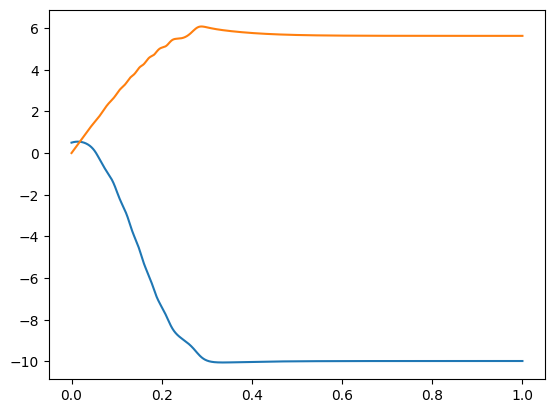

In [ ]:
import matplotlib.pyplot as plt
import scipy.integrate as mdl
import math
import numpy as np

#определим функцию для некотролируемого возмущения от времени
def zetaFunction(t):
    return (t % 19) + 4
#определим воздействие на систему (силу тока I на нагревательном элементе)
u = 3000000.0
#определим функцию, описывающую уравнения системы
def F(x, t):
    #zeta = zetaFunction(t)
    zeta = 4
    d_dP = -17*x[1] + zeta - 0.1*x[0]**3 + 9*math.sin(4*x[0] - 7) - 6
    d_T = -0.1*x[1]**3 - 2*x[1]*math.cos(5*x[0] + 6) + 30*math.tanh(u) - 1
    return [d_dP, d_T]

t = np.linspace(0, 1, 10000)
y = mdl.odeint(F, [0.5, 0.0], t)

plt.plot(t,y)
plt.show()

In [ ]:
print(t)

[0.00000000e+00 1.00010001e-04 2.00020002e-04 ... 9.99799980e-01
 9.99899990e-01 1.00000000e+00]


### 3. Моделирование САУ с цифровым ПИ-регулятором


Базовый пакет для моделирования контроллера

In [ ]:
!pip install digicon_mod

In [ ]:
import digicon_mod

Правая часть дифференциального уравнения объекта со ступенчатым изменением параметра

In [ ]:
def F_with_change(step_time, init_value, finish_value):
    def F_with_control(uc):
        def F_internal(x, t):
            if t > step_time:
                v0 = finish_value
            else:
                v0 = init_value
            return [ -math.pow(x[0],3) + x[1] + v0, -x[1] + uc]

        return F_internal
    return F_with_control

Реализация алгоритма ПИ-регулирования

In [ ]:
class PI(digicon_mod.plc.PLC):
    def __init__(self, goal, Kp, Ki, gain, step):
        super(PI,self).__init__(gain, step)
        self.Ki = Ki
        self.Kp = Kp
        self.goal = goal
        self.ei = 0

    def control(self, x, t):
        e = x[0] - self.goal
        self.ei = self.ei + e
        return self.Kp * e + self.Ki * self.ei

Вывод результатов моделирования

In [ ]:
def plot_result(time, time_end, x1, x2, plc, goal):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(time,x1, 'r-', time, x2, 'b-')
    plt.plot([0, time_end], [goal, goal], color='#FF0000',linestyle='--')
    plt.subplot(1,2,2)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(plc.t, plc.u,'b-',plc.t,plc.u_lim,'r-')
    plt.plot([0, tk], [1, 1], 'r--',[0, tk], [-1, -1], 'r--',[0, tk],[0, 0],'r:')
    plt.show()

Программа моделирования

In [ ]:
v0_init = 0.0
v0_finish = 1.0
change_time = 15
goal = 0.55
gain = 3.0
step = 0.5
mod_step = 0.1
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

plc=PI(goal=goal, Kp=-1.0, Ki=-0.05, gain=gain, step=step)
tk=30
x0=[-2.5, 0.1]
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, plc)
plot_result(time=res['t'], time_end=tk, x1=res['x1'], x2=res['x2'], plc=plc, goal=goal)